In [18]:
import sys
from tree_sitter import Language, Parser

sys.path.append('/home/CodeT5Experiments/CodeT5/parser/')
from DFG import DFG_python
from parser_utils import (remove_comments_and_docstrings,
                   tree_to_token_index,
                   index_to_code_token,
                   tree_to_variable_index,
                   tree_to_token_nodes)

In [19]:
# Load model directly
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codet5-small")

In [20]:
from datasets import load_dataset

dataset = load_dataset("code_x_glue_ct_code_to_text", "python")

In [4]:
from tqdm import tqdm
code_tokens_lengths = []
nl_lengths = []
for i in tqdm(range(len(dataset['train']))):
    unintended_code = ' '.join(dataset['train'][i]['code_tokens']).replace('\n', ' ')
    nl = ' '.join(dataset['train'][i]['docstring_tokens']).replace('\n', ' ')
    code_tokens_lengths.append(len(unintended_code))
    nl_lengths.append(len(nl))
    #code = dataset['train'][i]['code']
    #tree = parsers['python'][0].parse(bytes(code,'utf8')) 
    #root_node = tree.root_node
    #ast_preorder = preorder_traversal(root_node)
    #code_output = tokenizer.encode(unintended_code)
    #ast_output = tokenizer.encode('<AST>' + ast_preorder)
    

100%|██████████| 251820/251820 [03:05<00:00, 1360.54it/s]


In [7]:
import matplotlib.pyplot as plt

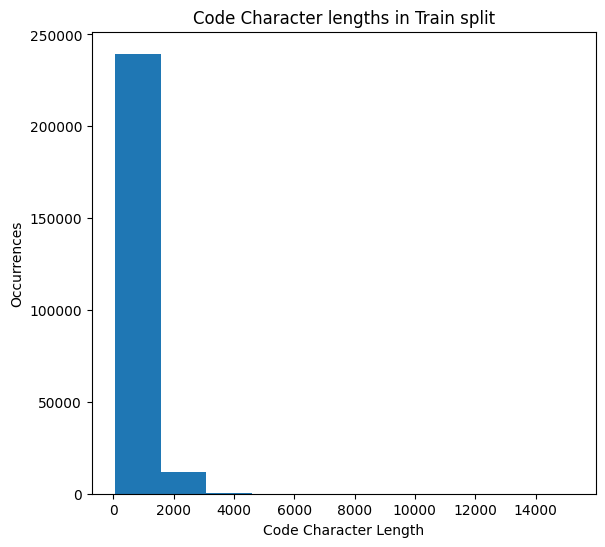

In [15]:
plt.figure(figsize=[6.5, 6])
plt.hist(code_tokens_lengths, density=False)
plt.xlabel("Code Character Length")
plt.ylabel("Occurrences")
plt.title("Code Character lengths in Train split")
plt.savefig("Code_Charcter.svg")
plt.show()

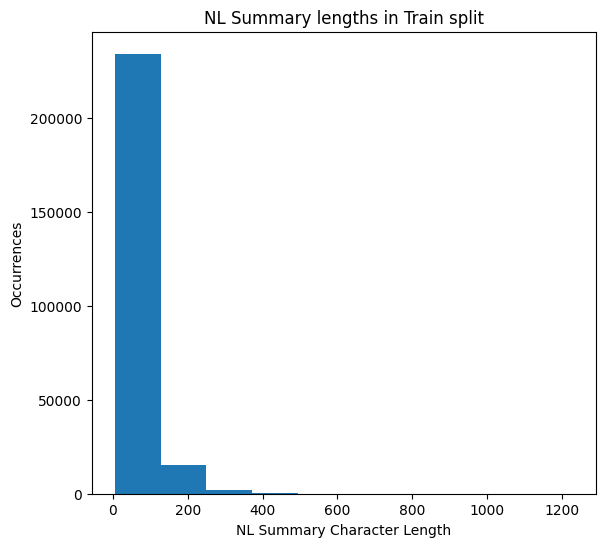

In [16]:
plt.figure(figsize=[6.5, 6])
plt.hist(nl_lengths, density=False)
plt.xlabel("NL Summary Character Length")
plt.ylabel("Occurrences")
plt.title("NL Summary lengths in Train split")
plt.savefig("NL_Charcter.svg")
plt.show()

In [6]:
dataset['train'][0].keys()

dict_keys(['id', 'repo', 'path', 'func_name', 'original_string', 'language', 'code', 'code_tokens', 'docstring', 'docstring_tokens', 'sha', 'url'])

In [38]:
code_example = dataset['train'][0]['code']
code_example = """
def add(a, b, c):
    z = a + b
    d = 10*c
    return z + d
"""

In [22]:
dfg_function={
'python':DFG_python
}

In [23]:
parsers={}        
for lang in dfg_function:
    LANGUAGE = Language('/home/CodeT5Experiments/CodeT5/parser/my-languages2.so', lang)
    parser = Parser()
    parser.set_language(LANGUAGE) 
    parser = [parser,dfg_function[lang]]    
    parsers[lang]= parser


In [39]:
# Add AST.
tree = parsers['python'][0].parse(bytes(code_example,'utf8')) 
root_node = tree.root_node

In [40]:
# DFG.
ast_token_nodes = tree_to_token_nodes(root_node)
tokens_index = [(node.start_point, node.end_point) for node in ast_token_nodes]
original_code=code_example.split('\n')
code_tokens=[index_to_code_token(x,original_code) for x in tokens_index] 
index_to_code={index:(idx,code_) for idx,(index,code_) in enumerate(zip(tokens_index,code_tokens))}

try:
    dfg,_ = DFG_python(root_node,index_to_code,{}) 
except Exception as e:
    dfg = []
    print(str(e))
for d in dfg:
    assert (d[2]=='comesFrom' or d[2]=='computedFrom')
dfg = [(d[1], d[4]) for d in dfg if (len(d[4])>0)] # left comes from right
original_dfg = dfg
# Format: (indentifier_count)
count = {}
new_mapping = []
for i in code_tokens:
    if i in count:
        count[i] += 1
    else:
        count[i] = 0
    new_mapping.append(i + '_' + str(count[i]))
dfg = [(new_mapping[int(x)], [new_mapping[z] for z in y]) for x,y in dfg]
print(dfg)

[('z_0', ['a_1', 'b_1']), ('a_1', ['a_0']), ('b_1', ['b_0']), ('d_0', ['10_0', 'c_1']), ('c_1', ['c_0']), ('z_1', ['z_0']), ('d_1', ['d_0'])]


In [41]:
dfg = str(dfg).replace("'", "").replace('(','').replace(')', '')
print(dfg)

[z_0, [a_1, b_1], a_1, [a_0], b_1, [b_0], d_0, [10_0, c_1], c_1, [c_0], z_1, [z_0], d_1, [d_0]]


In [46]:
concise_dfg = set()
for x,y in original_dfg:
    if len(y) == 1 and code_tokens[x] == code_tokens[y[0]]:
        continue
    valid = (code_tokens[x], tuple([code_tokens[z] for z in y]))
    concise_dfg.add(valid)
print(str(concise_dfg).replace("'",'').replace('{','').replace('}',''))

(d, (10, c)), (z, (a, b))


In [14]:
ast = root_node.sexp()
ast

'(module (function_definition name: (identifier) parameters: (parameters (identifier) (identifier)) body: (block (if_statement condition: (comparison_operator (call function: (identifier) arguments: (argument_list (identifier))) (integer)) consequence: (block (return_statement (call function: (attribute object: (identifier) attribute: (identifier)) arguments: (argument_list (parenthesized_expression (integer))))))) (return_statement (call function: (attribute object: (attribute object: (identifier) attribute: (identifier)) attribute: (identifier)) arguments: (argument_list (binary_operator left: (identifier) right: (identifier)) (keyword_argument name: (identifier) value: (integer))))))))'

In [36]:
ast_preorder = preorder_traversal(root_node)
ast_preorder

'module function_definition def identifier <face_distance> parameters ( identifier <face_encodings> , identifier <face_to_compare> ) : block if_statement if comparison_operator call identifier <len> argument_list ( identifier <face_encodings> ) == integer <0> : block return_statement return call attribute identifier <np> . identifier <empty> argument_list ( parenthesized_expression ( integer <0> ) ) return_statement return call attribute attribute identifier <np> . identifier <linalg> . identifier <norm> argument_list ( binary_operator identifier <face_encodings> - identifier <face_to_compare> , keyword_argument identifier <axis> = integer <1> ) '

In [12]:
ast_preorder = preorder_traversal(root_node)
ast_preorder

'<MODULE> <FUNCTION_DEFINITION> <DEF> <IDENTIFIER> <PARAMETERS> <(> <IDENTIFIER> <,> <IDENTIFIER> <,> <DEFAULT_PARAMETER> <IDENTIFIER> <=> <STRING> <"> <"> <)> <:> <BLOCK> <EXPRESSION_STATEMENT> <STRING> <"> <"> <EXPRESSION_STATEMENT> <CALL> <ATTRIBUTE> <IDENTIFIER> <.> <IDENTIFIER> <ARGUMENT_LIST> <(> <IDENTIFIER> <,> <KEYWORD_ARGUMENT> <IDENTIFIER> <=> <IDENTIFIER> <,> <KEYWORD_ARGUMENT> <IDENTIFIER> <=> <IDENTIFIER> <)> '

In [13]:
from tqdm import tqdm
for i in tqdm(range(len(dataset['train']))):
    tree = parsers['python'][0].parse(bytes(dataset['train'][i]['code'],'utf8')) 
    root_node = tree.root_node
    ast_preorder = preorder_traversal(root_node)

100%|██████████| 251820/251820 [02:46<00:00, 1508.37it/s]


In [14]:
additional_tokens = ['<DENOISE>', '<AST>', '<DFG>']
additional_tokens.extend(list(unique))
special_tokens_dict = {'additional_special_tokens': additional_tokens}

num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

In [15]:
input_sequence_limits = [-1, 128, 256, 512]
for seq_limit in input_sequence_limits:
    if seq_limit == -1:
        for i in tqdm(range(len(dataset['train']))):
            unintended_code = ' '.join(dataset['train'][i]['code_tokens']).replace('\n', ' ')
            code = dataset['train'][i]['code']
            tree = parsers['python'][0].parse(bytes(code,'utf8')) 
            root_node = tree.root_node
            ast_preorder = preorder_traversal(root_node)
            code_output = tokenizer.encode(unintended_code)
            ast_output = tokenizer.encode('<AST>' + ast_preorder)
            break
    else:
        pass
    break

  0%|          | 0/251820 [00:00<?, ?it/s]


In [16]:
tokenizer.decode(code_output)

"<s>def settext ( self, text, cls = 'current' ) : self. replace ( TextContent, value = text, cls = cls )</s>"

In [17]:
tokenizer.decode(ast_output)

'<s><AST><MODULE> <FUNCTION_DEFINITION> <DEF> <IDENTIFIER> <PARAMETERS> <(> <IDENTIFIER> <,> <IDENTIFIER> <,> <DEFAULT_PARAMETER> <IDENTIFIER> <=> <STRING> <"> <"> <)> <:> <BLOCK> <EXPRESSION_STATEMENT> <STRING> <"> <"> <EXPRESSION_STATEMENT> <CALL> <ATTRIBUTE> <IDENTIFIER> <.> <IDENTIFIER> <ARGUMENT_LIST> <(> <IDENTIFIER> <,> <KEYWORD_ARGUMENT> <IDENTIFIER> <=> <IDENTIFIER> <,> <KEYWORD_ARGUMENT> <IDENTIFIER> <=> <IDENTIFIER> <)> </s>'

In [18]:
len(dataset['train'])

251820

In [19]:
import numpy as np

In [20]:
lengths_array = np.zeros((len(dataset['train']), 3))
lengths_array.shape

(251820, 3)

In [21]:
input_sequence_limits = [-1, 128, 256, 512]
for seq_limit in input_sequence_limits:
    if seq_limit == -1:
        for i in tqdm(range(len(dataset['train']))):
            unintended_code = ' '.join(dataset['train'][i]['code_tokens']).replace('\n', ' ')
            code = dataset['train'][i]['code']
            tree = parsers['python'][0].parse(bytes(code,'utf8')) 
            root_node = tree.root_node
            ast_preorder = preorder_traversal(root_node)
            code_output = tokenizer.encode(unintended_code)
            ast_output = tokenizer.encode('<AST>' + ast_preorder)
            lengths_array[i] = len(code_output), len(ast_output), len(code_output) + len(ast_output) - 1
    else:
        for i in tqdm(range(len(dataset['train'])), desc=f'Input sequence length: {seq_limit}'):
            unintended_code = ' '.join(dataset['train'][i]['code_tokens']).replace('\n', ' ')
            code = dataset['train'][i]['code']
            tree = parsers['python'][0].parse(bytes(code[:seq_limit],'utf8')) 
            root_node = tree.root_node
            ast_preorder = preorder_traversal(root_node)
            code_output = tokenizer.encode(unintended_code[:seq_limit])
            ast_output = tokenizer.encode('<AST>' + ast_preorder)
            lengths_array[i] = len(code_output), len(ast_output), len(code_output) + len(ast_output) - 1


Input sequence length: 256:  57%|█████▋    | 143809/251820 [03:27<02:35, 693.00it/s]


KeyboardInterrupt: 